In [2]:
## Load libraries.
import json
import gzip
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import string
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

pd.set_option('display.max_rows', 999)
pd.set_option('precision', 5)
% matplotlib inline
sns.set_style('whitegrid')

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.
/Users/millenium/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
## Load data.
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 

def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index')
def getFilterDF(path,col="",val=[]): 
    i = 0 
    df = {} 
    for d in parse(path): 
        if(d[col] in val):
            df[i] = d 
            i += 1 
    return pd.DataFrame.from_dict(df, orient='index')
def getDataByRegx(df_meta,file_review,reg_exp,t_price=0):
    df_filter=df.loc[(df.title.str.lower().str.match(reg_exp).str.len()>0) & (df.price>t_price),:]
    id2filter=df_filter.asin.values
    #load 
    df_review = getFilterDF(file_review,'asin',id2filter)
    df_review['rvw_date']=df_review.reviewTime.str.match(r'(\d{2}) (\d*), (\d{4})').map(lambda t:t[2]+'/'+t[0]+'/'+t[1])
    df_review['rvw_date']=pd.to_datetime(df_review['rvw_date'],infer_datetime_format=True)
    df_data=pd.merge(df_review, df_filter, how='inner', on=['asin'], copy=True, indicator=False)
    return df_data
df = getDF('meta_Cell_Phones_and_Accessories.json.gz')

In [61]:
#We filter the references of the desire products
df_data_smg=getDataByRegx(df,'reviews_Cell_Phones_and_Accessories.json.gz',
                      r'(samsung)',t_price=100)

/Users/millenium/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.
/Users/millenium/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.


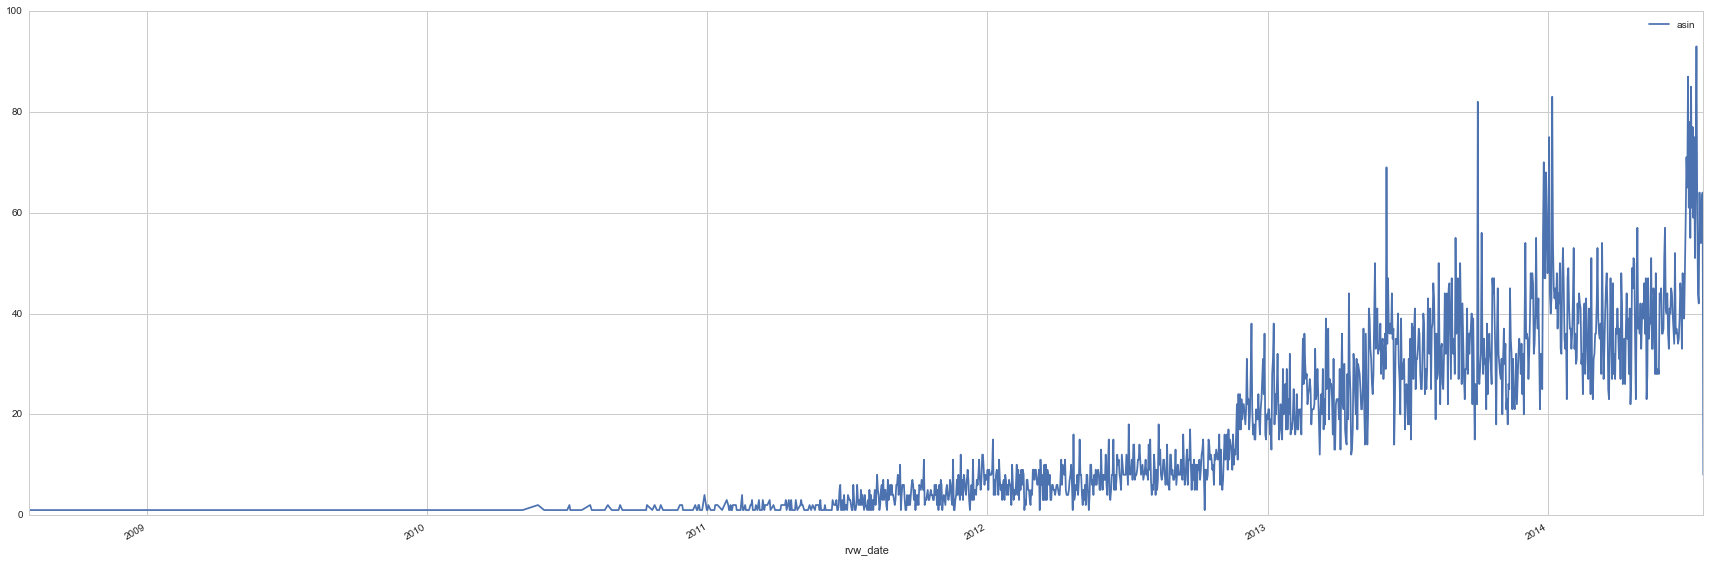

In [62]:
data_s = (df_data_smg[['rvw_date','asin']].groupby(['rvw_date']).count()).plot(figsize=(30,10 ))

In [76]:
import numpy
df_corr_s=getStock('005930.KS','2012-06-01','2013-07-01',df_data_smg)
numpy.corrcoef(df_corr_s['Close'].values,df_corr_s['overall2'].values)

array([[ 1.        ,  0.75758924],
       [ 0.75758924,  1.        ]])

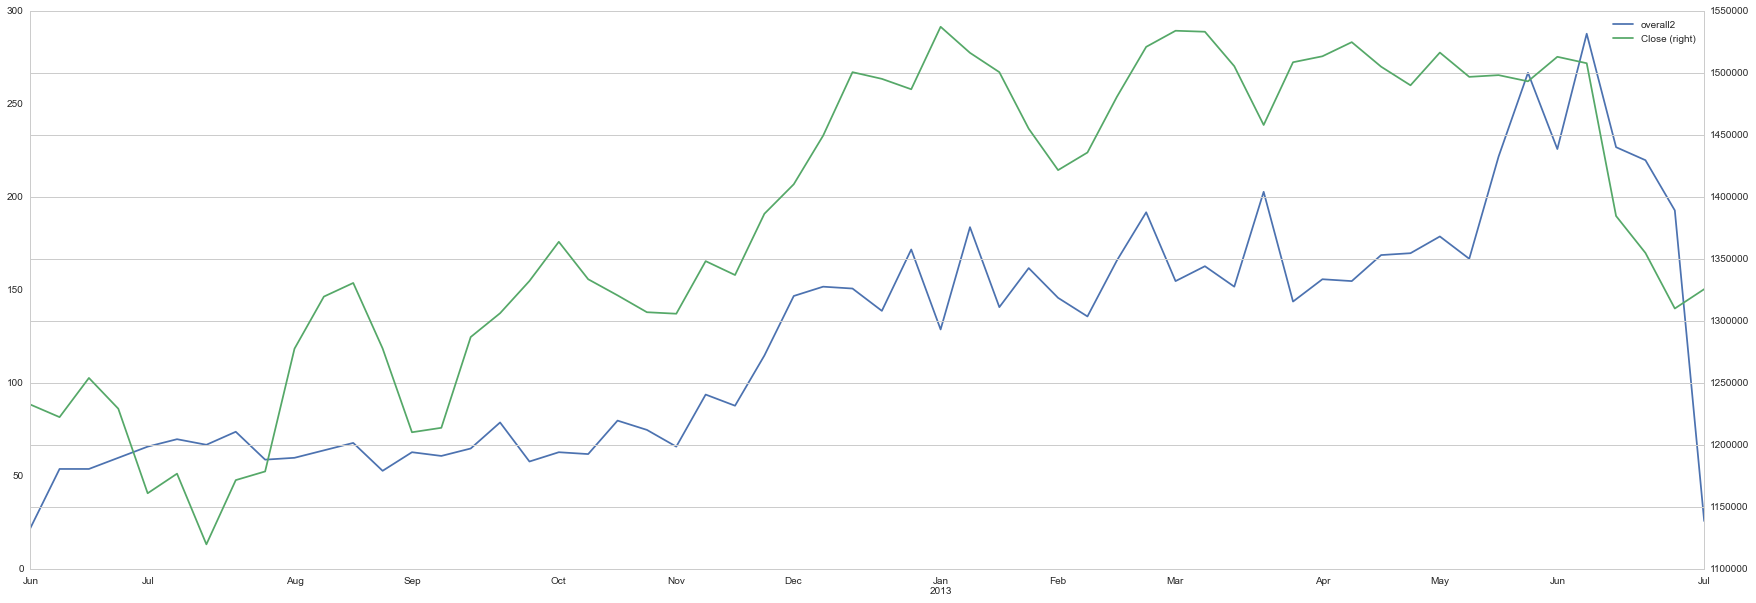

In [77]:
df_corr_s[['Close','overall2']].plot(figsize=(30,10 ), secondary_y='Close',y=['overall2','Close'])

In [53]:
df_data_htc=getDataByRegx(df,'reviews_Cell_Phones_and_Accessories.json.gz',r'(htc)',t_price=50)
df_data_htc.shape

/Users/millenium/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.
/Users/millenium/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.


(9286, 18)

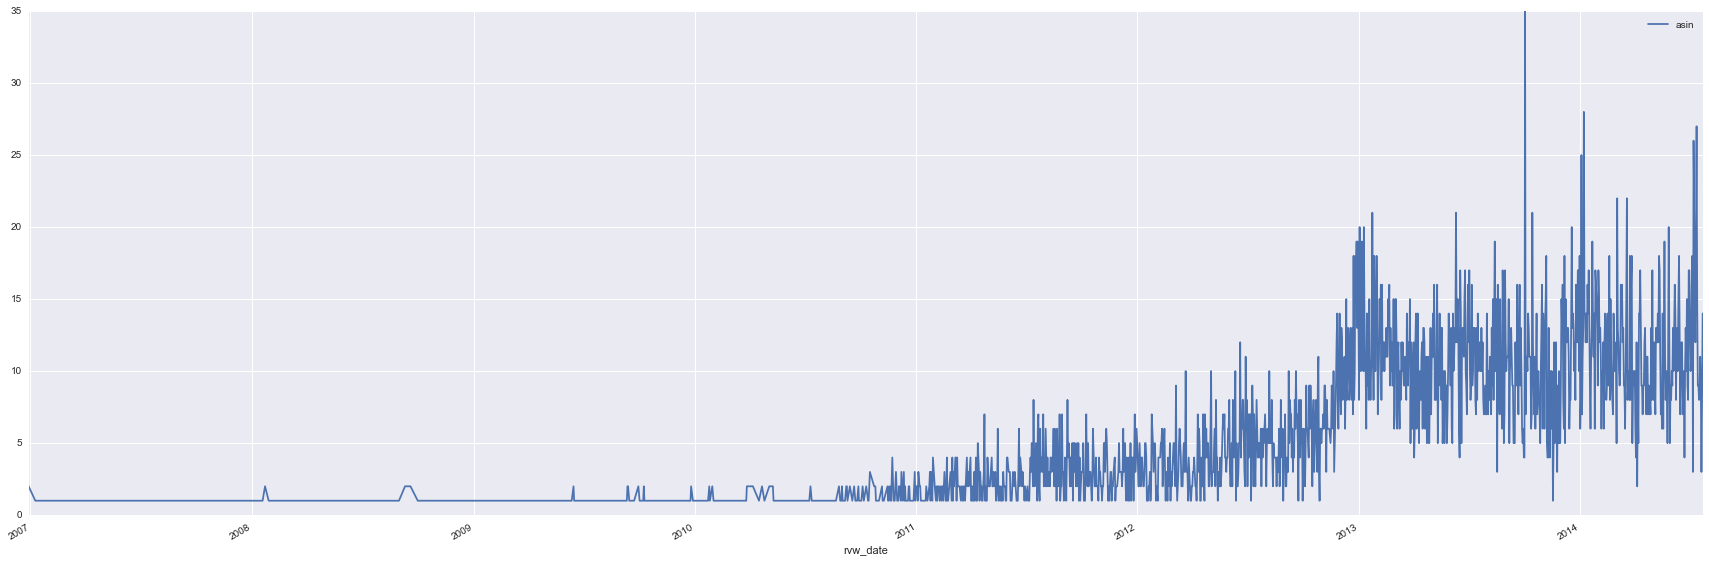

In [306]:
data = (df_data_htc[['rvw_date','asin']].groupby(['rvw_date']).count()).plot(figsize=(30,10 ))

In [54]:
import ystockquote
from pprint import pprint
#2498.TW HTC
#005930 SAMSUNG
#'2006-12-24', '2014-07-27'
def getStock(name,date_ini,date_end,df_rw):
    dic_stock=ystockquote.get_historical_prices(name, date_ini, date_end)
    df_stock=pd.DataFrame.from_dict(dic_stock, orient='index')
    df_stock.index=(pd.to_datetime(df_stock.index))
    df_stock['Close']=pd.to_numeric(df_stock['Close'])
    df_wstock=df_stock[['Close']].resample('W', how='mean')
    df_rw.index=(pd.to_datetime(df_rw.rvw_date))
    df_rw['overall2']=3-df_rw[['overall']]
    df_rw=df_rw.loc[(df_rw.rvw_date >=date_ini)&(df_rw.rvw_date <=date_end)]
    df_wreview=df_rw[['overall2']].resample('W', how='count')
    df_corr=df_wstock.merge(df_wreview, left_index=True, right_index=True, how='outer')
    df_corr=df_corr.fillna(0)
    return df_corr

In [82]:
import numpy
df_corr=getStock('2498.TW','2012-11-01','2013-07-15',df_data_htc)
numpy.corrcoef(df_corr['Close'].values,df_corr['overall2'].values)

array([[ 1.        ,  0.61354258],
       [ 0.61354258,  1.        ]])

In [415]:

grouped = (df_data_htc
    .groupby(['overall'])                
    .apply(lambda g:               # work on groups of col1
        g.set_index('rvw_date')        
        [['overall']]
        .resample('W', how='count')  # sum the amount field across weeks
    )
    .unstack(level=0)              # pivot the col1 index rows to columns
    .fillna(0)
)
grouped.columns=grouped.columns.droplevel()   # drop the 'col1' part of the multi-index column names

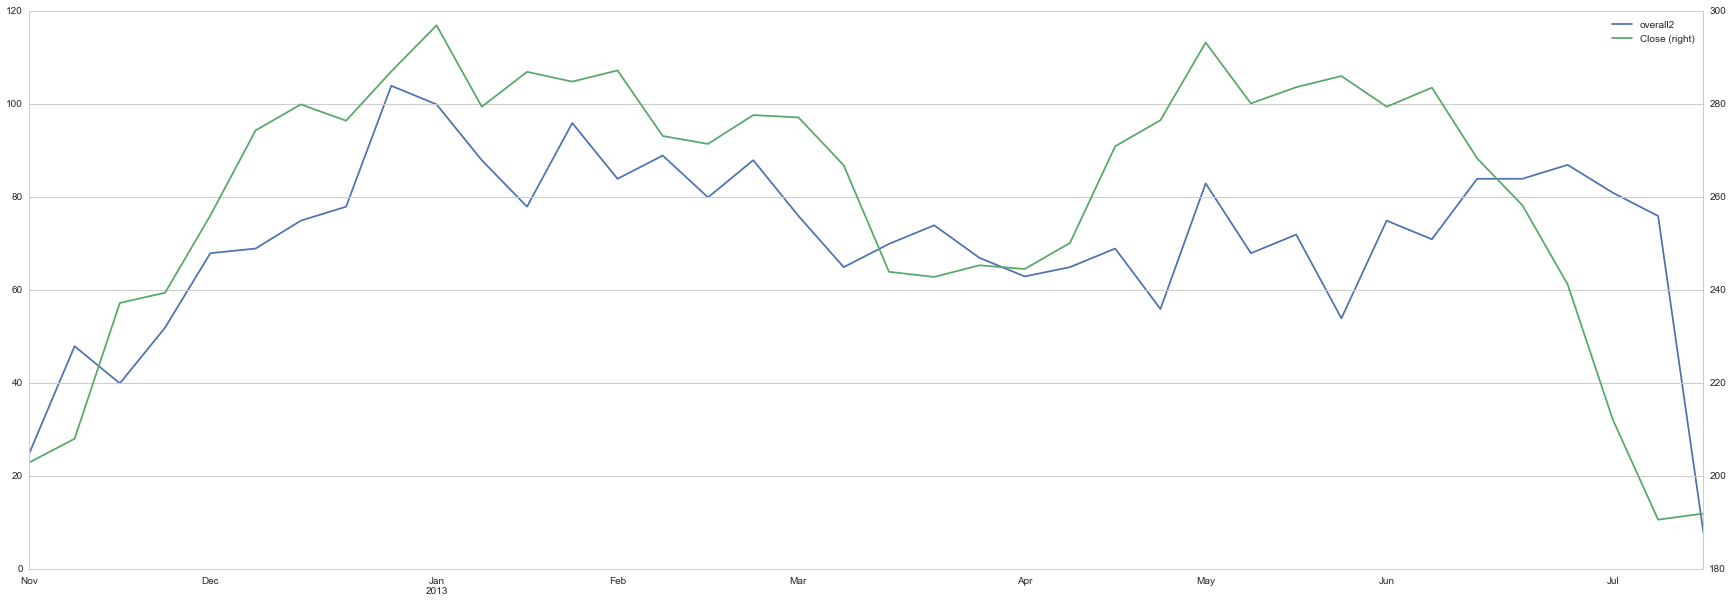

In [83]:
df_corr[['Close','overall2']].plot(figsize=(30,10 ),  secondary_y='Close',y=['overall2','Close'])

## DataSet
We filtered our dataset with an specific domain. It contains all the reviews realted with cellphones.

In [4]:
#Run to Label
df_data_cel=getDataByRegx(df,'reviews_Cell_Phones_and_Accessories.json.gz',
                          r'(iphone)|(samsung)|(ipad)|(htc)',t_price=100)
df_label=df_data_cel.loc[df_data_cel.helpful.map(lambda x: x[1]>=10)]
df_label_aux=df_label.sample(500,random_state=1)
df_label_aux[['unixReviewTime','reviewerID','asin','reviewText']].to_csv('label_p2',sep='^')

/Users/millenium/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.
/Users/millenium/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.


In [34]:
#Load our label Data
data_label_vp=pd.read_csv("label_vp.csv",sep=";")
data_sam_label=df_data_cel.merge(data_label_vp,on=['unixReviewTime','reviewerID','asin'], how='inner')
print data_sam_label.shape
print df_data_cel.shape

(495, 19)
(30877, 18)


In [ ]:
from clean_helpful import helpful_classifier,tokenize
helpful_classifier(df_data_cel, "Random_Forest.pkl", "tfidf_mat.bin")

('DATA SIZE:', (30873, 18))
('Anatomical Features:', (30873, 6))
('Metada Features:', (30873, 2))

## Feature Extraction Model

In [41]:
import nltk
import string
import pandas as pd
import re
import gzip 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
import sklearn.feature_extraction.text as text
from sklearn import decomposition
class ModelTF(object):
    tfidf=None
    result=False
    def __init__(self,data_train):
        ngram_extraction(data_train['reviewText'],train=True)
        
    def __init__(self, data_train,data_transform):
        feat_data=self.__feature_extration(data_transform)
        self.__ngram_extraction(data_train['reviewText'],train=True)
        ngram_data=self.__ngram_extraction(data_transform['reviewText'],train=False)
        self.result=np.concatenate([np.matrix(feat_data),np.matrix(ngram_data)] , axis=1)
        
    def feature_extration(self,data):
        def upper_count(lt):
            return sum(1 for x in lt if x.isupper())
        length = data['reviewText'].str.split(" ").apply(len)
        sentences = data['reviewText'].str.split(".").apply(len)
        characters = data['reviewText'].apply(len)
        exclamation = data['reviewText'].str.count("!")
        question = data['reviewText'].str.count("\?")
        upper_words = data['reviewText'].str.split(" ").apply(upper_count)

        anatomical = pd.concat([length, sentences, 
                                characters, exclamation,
                                question, upper_words], axis = 1)
        scores = data['overall']
        averages = data[['overall', 'asin']].groupby('asin').mean()
        averages = pd.DataFrame({'asin': list(averages.index), 
                                 'avg': np.ravel(averages.values)})
        deviation = pd.merge(data[['overall', 'asin']], averages, on = 'asin')
        deviation = np.abs( deviation['overall'] - deviation['avg'] )
        metadata = pd.concat([scores.reset_index(drop=True),
                              deviation.reset_index(drop=True)
                             ], 
                              axis = 1)
        result = pd.concat([anatomical.reset_index(drop=True),
                              metadata.reset_index(drop=True)
                             ], 
                              axis = 1)
        return result


    def ngram_extraction(self,data,train=True):

        stemmer = PorterStemmer()
        translator = string.maketrans(string.punctuation, ' '*len(string.punctuation))

        def stem_tokens(tokens, stemmer):
            stemmed = []
            for item in tokens:
                stemmed.append(stemmer.stem(item))
            return stemmed

        def tokenize(text):
            text = re.sub(r"\W", " ", text)
            text = re.sub(r'\d+', '', text)
            tokens = nltk.word_tokenize(text)
            filtered_words = [word for word in tokens if word not in stopwords.words('english')]
            stems = stem_tokens(filtered_words, stemmer)
            return stems
        def tf_idf(pd_text):
            lowers = pd_text.apply(lambda x: x.lower())
            no_punctuation = lowers.apply(lambda x: x.translate(translator))
            token_dict = no_punctuation.to_dict()
            tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
            tfs = tfidf.fit_transform(token_dict.values())
            return tfidf,pd.DataFrame(tfs.todense())
        def tf_idf_test(pd_text,tfidf):
            lowers = pd_text.apply(lambda x: x.lower())
            no_punctuation = lowers.apply(lambda x: x.translate(translator))
            token_dict = no_punctuation.to_dict()
            tfs = tfidf.transform(token_dict.values())
            return pd.DataFrame(tfs.todense())
        if(train):
            self.tfidf,result=tf_idf(data)
        else:
            result=tf_idf_test(data,self.tfidf)
        return result

    __feature_extration = feature_extration
    __ngram_extraction = ngram_extraction
modelTF=ModelTF(df_data_cel,data_sam_label)
matrix_x=modelTF.result

(30877, 25219)


## Models
We have few Labeled data. Therefore we are going to run different experiemtns with a 5-fold. Also we test RandomForest and LogisticRegression.

In [48]:
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

def train_model(X,y):
    def choose_param_lg(X,y):
        fold = KFold(len(y), n_folds=5, shuffle=True, random_state=777)
        grid = {
            'C': np.power(10.0, np.arange(-10, 10))
             , 'solver': ['newton-cg'],
            "class_weight":["balanced",None]
        }
        clf = LogisticRegression(penalty='l2', random_state=777, max_iter=10000, tol=10 )
        gs = GridSearchCV(clf, grid, scoring='accuracy', cv=fold)
        gs.fit(X, y)
        print ('gs.best_score_:', gs.best_score_,gs.best_params_)
        return gs,clf
    
    def choose_param_rf(X,y):
        fold = KFold(len(y), n_folds=5, shuffle=True, random_state=777)
        clf = RandomForestClassifier(n_estimators=20)
        param_dist = {"max_depth": [3,5, None],
                      "max_features": ['sqrt',200,300],
                      "bootstrap": [True, False],
                      "criterion": ["gini", "entropy"],
                      "class_weight":["balanced",None]}
        gs = GridSearchCV(clf, param_grid=param_dist,cv=fold)
        gs.fit(X, y)
        print ('gs.best_score_:', gs.best_score_,gs.best_params_)
        return gs,clf
    gs_rf,model_rf=choose_param_rf(X,y)
    gs_lg,model_lg=choose_param_lg(X,y)
    if(gs_rf.best_score_>gs_lg.best_score_):
        return model_rf
    else:
        return model_lg

X=np.matrix(matrix_x)
y=data_sam_label['target'].fillna(0).values
model=train_model(X,y)

('gs.best_score_:', 0.78585858585858581, {'max_features': 300, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'class_weight': None})
('gs.best_score_:', 0.80202020202020197, {'C': 1000.0, 'solver': 'newton-cg', 'class_weight': None})


In [ ]:
model.predict()